## 1. Install Dependencies and Setup


In [ ]:
#import necessary libraries
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#### 1.1 Import Dataset:

In [ ]:
dataset=pd.read_csv("EngineFaultDB_Final.csv")
dataset.head()

,Fault,MAP,TPS,Force,Power,RPM,Consumption L/H,Consumption L/100KM,Speed,CO,HC,CO2,O2,Lambda,AFR
0,0,3.549,1.889,7.428,5.227,1192.769,3.057,11.720,24.901,0.460,196.089,14.356,1.080,1.047,15.385
1,0,3.559,1.899,7.646,5.327,1145.191,2.914,11.276,25.030,0.478,196.283,14.492,1.107,1.083,15.926
2,0,3.539,1.899,7.578,5.100,1208.505,2.976,11.926,24.213,0.464,200.367,14.443,1.099,1.072,15.754
3,0,3.519,1.889,7.371,5.255,1164.127,2.908,11.786,24.407,0.471,195.345,13.853,1.076,1.006,14.787
4,0,3.549,1.879,7.405,5.177,1172.032,2.898,12.169,24.875,0.468,194.979,13.752,1.060,0.984,14.470


#### 1.2 Data Visualisation and Preprocessing


We get to know our dataset through looking at the different data categories, as well as the statistical description. We also take a look at the amount of null data to possibly fill it in if required.


In [ ]:
# Check the unique values for label column "Fault"
dataset["Fault"].unique()

array([0, 1, 2, 3])

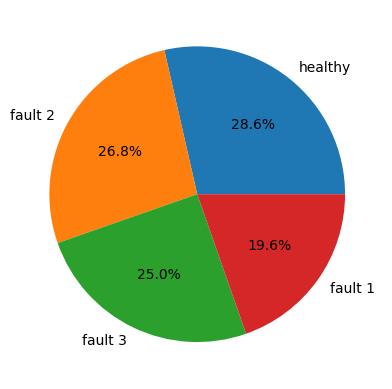

In [ ]:
count= dataset['Fault'].value_counts() #get the frequency of different labels
plt.pie(x=count.values, labels=['healthy','fault 2', 'fault 3','fault 1'], autopct='%1.1f%%')
plt.show()

In [ ]:
count

Fault
0    16000
2    15000
3    14001
1    10998
Name: count, dtype: int64

#### Check for null values:

In [ ]:
dataset.isnull().sum()

Fault                  0
MAP                    0
TPS                    0
Force                  0
Power                  0
RPM                    0
Consumption L/H        0
Consumption L/100KM    0
Speed                  0
CO                     0
HC                     0
CO2                    0
O2                     0
Lambda                 0
AFR                    0
dtype: int64

#### Look at the statistical information about our Dataset:

In [ ]:
#Take a look at the dataset using "Describe"
dataset.describe()

,Fault,MAP,TPS,Force,Power,RPM,Consumption L/H,Consumption L/100KM,Speed,CO,HC,CO2,O2,Lambda,AFR
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000
mean,1.482187,1.832515,1.395269,286.691705,5.657126,2398.053774,4.497634,8.939794,51.688740,1.932430,188.446083,13.035230,0.585910,0.963907,14.169408
std,1.149430,0.837786,0.906950,378.774917,7.684147,932.008680,2.221497,3.154110,20.140345,1.988789,111.047015,1.046567,0.223713,0.065973,0.969802
min,0.000000,0.453000,0.382000,2.580000,0.465000,1066.452000,1.917000,5.187000,22.757000,0.421000,1.787000,8.649000,0.203000,0.695000,10.210000
25%,0.000000,1.217000,0.901000,76.848500,0.994000,1830.200500,2.981000,6.573000,39.412000,0.641000,158.803000,12.842000,0.415000,0.937000,13.780000
50%,2.000000,1.543000,1.013000,92.500000,2.398000,2105.588000,3.824000,8.068000,45.393000,1.129000,178.265000,13.242000,0.533000,0.977000,14.365000
75%,3.000000,1.940000,1.258000,257.989500,4.696000,2761.373500,5.144500,9.924000,59.508000,2.455000,203.678000,13.639000,0.789000,1.008000,14.823000
max,3.000000,4.547000,4.048000,1537.118000,33.946000,5013.402000,14.810000,20.043000,107.539000,10.132000,975.657000,15.129000,1.151000,1.149000,16.893000


## 2. Prepare the Dataset for Training our Autoencoder:

This dataset contains 4 categories of faulty engine data:
- No fault (0)
- Fault type 1
- Fault type 2
- Fault type 3

As we are trying to get the autoencoder to realise what "healthy" engine data looks like, we don't need the faulty data, so the first step is to create a dataset of only the healthy data:


#### 2.1 Create the healthy dataset:

In [ ]:
#Create a dataset for the healthy data:
healthy_dataset = dataset[dataset['Fault']== 0] #Healthy Dataset


In [ ]:
healthy_dataset.shape

(16000, 15)

In [ ]:
#Doublecheck if there are only healthy data within the healthy dataset:
healthy_dataset["Fault"].unique()


array([0])

In [ ]:
#Remove the "Fault column" as we don't need it to understand the behavior of the data:
healthy_dataset = healthy_dataset.drop("Fault", axis=1)


In [ ]:
healthy_dataset.shape

(16000, 14)

In [ ]:
# This is the feature vector that goes to the neural net
healthy_input = healthy_dataset.values


#### 2.2 Train and Test Split

First generate the train and test split.
Then normalise the training data. Afterwards, perform normalisation on testing samples as well, but this time using the mean and variance of training  variables. In this way, we can test and evaluate whether our model can generalize well to new, unseen data points.


In [ ]:
from sklearn.model_selection import train_test_split

healthy_train, healthy_test = train_test_split(
        healthy_input, test_size=0.2, random_state=42)

print(f"Good train count: {len(healthy_train)}")
print(f"Good test count: {len(healthy_test)}")

#

Good train count: 12800
Good test count: 3200


It's good practice to normalise input data to the model. This can assist your eeural network to learn faster.

In [ ]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

pipeline.fit(healthy_train);

In [ ]:
# transform the training and validation data with these parameters
train_transformed = pipeline.transform(healthy_train)
test_transformed = pipeline.transform(healthy_test)

## 3. Model Engineering and Training

### 3.1 Model Engineering

In [ ]:
# get the input dimension for model which will be the number of features (Columns). In our case this is 14.
input_dimension=train_transformed.shape[1]

In [ ]:
########
#Define the autoencoder model
#Since we're dealing with numeric values we can use only Dense layers.

from sklearn import metrics
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(10, input_dim=input_dimension, activation='relu'))#input dimensions equal to number of features/columns
model.add(Dense(3, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(input_dimension)) #output dimensions equal to number of features/columns as we reconstructing the data







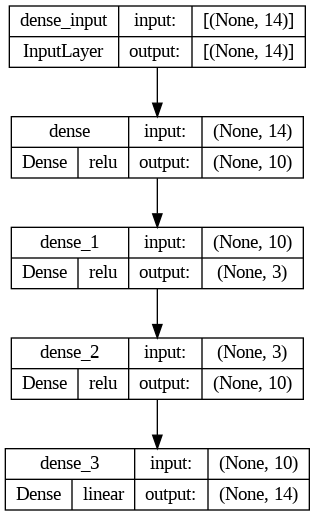

In [ ]:

#Visualise the model we created.
import tensorflow as tf
tf.keras.utils.plot_model(model, rankdir="TB", show_shapes=True, show_layer_activations=True,show_layer_names=True)


In [ ]:
# Specify the loss and optimiser
model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
#Look at the model's summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                150       
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
 dense_2 (Dense)             (None, 10)                40        
                                                                 
 dense_3 (Dense)             (None, 14)                154       
                                                                 
Total params: 377 (1.47 KB)
Trainable params: 377 (1.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3.2 Model Training

In [ ]:
BATCH_SIZE = 1026
EPOCHS = 200
history = model.fit(train_transformed, train_transformed,
                    verbose=1, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(test_transformed, test_transformed))

Epoch 1/200
13/13 [==============================] - 4s 18ms/step - loss: 0.2752 - val_loss: 0.2572
Epoch 2/200
13/13 [==============================] - 0s 5ms/step - loss: 0.2492 - val_loss: 0.2376
Epoch 3/200
13/13 [==============================] - 0s 7ms/step - loss: 0.2314 - val_loss: 0.2216
Epoch 4/200
13/13 [==============================] - 0s 6ms/step - loss: 0.2156 - val_loss: 0.2058
Epoch 5/200
13/13 [==============================] - 0s 5ms/step - loss: 0.1998 - val_loss: 0.1899
Epoch 6/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1838 - val_loss: 0.1738
Epoch 7/200
13/13 [==============================] - 0s 10ms/step - loss: 0.1676 - val_loss: 0.1574
Epoch 8/200
13/13 [==============================] - 0s 10ms/step - loss: 0.1511 - val_loss: 0.1410
Epoch 9/200
13/13 [==============================] - 0s 6ms/step - loss: 0.1348 - val_loss: 0.1249
Epoch 10/200
13/13 [==============================] - 0s 5ms/step - loss: 0.1191 - val_loss: 0.1097
Epoch

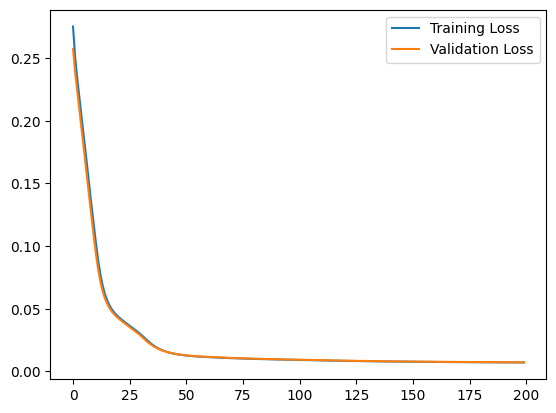

In [ ]:
#Visualise the history of training"
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


## 4. Testing the Hypothesis:

First let's create the faulty dataset as we've done for test and training:
1. Drop the fault label
2. Normalise based on the pipeline before


In [ ]:
fault1_dataset = dataset[dataset['Fault']==1] #Unhealthy Dataset

fault1_dataset= fault1_dataset.drop("Fault", axis=1)
fault_type1= fault1_dataset.values
faulty_transformeddata= pipeline.transform(fault_type1)

Calculate the mean absolute error between the reconstructions and real faulty data. We will then compare it to the mean absolute error for training and testing. The error should be atleast 50% higher than that of the healthy data.

In [ ]:

reconstruction_faulty = model.predict(faulty_transformeddata)
reconstruction_loss_anomalous =  np.mean(np.abs(faulty_transformeddata - reconstruction_faulty), axis=1)


344/344 [==============================] - 1s 2ms/step


In [ ]:
reconstructions = model.predict(train_transformed)
reconstruction_errors_normal_train = np.mean(np.abs(train_transformed - reconstructions), axis=1)


400/400 [==============================] - 1s 2ms/step


In [ ]:

reconstructions = model.predict(test_transformed)
reconstruction_errors_normal_test = np.mean(np.abs(test_transformed - reconstructions), axis=1)




100/100 [==============================] - 0s 1ms/step


In [ ]:


print(f"Average Reconstruction Loss for test Data: {np.mean(reconstruction_errors_normal_test)}")
print(f"Average Reconstruction Loss for train Data: {np.mean(reconstruction_errors_normal_train)}")
print(f"Average Reconstruction Loss for Anomalous Data: {np.mean(reconstruction_loss_anomalous)}")


Average Reconstruction Loss for test Data: 0.055679310308828465
Average Reconstruction Loss for train Data: 0.055328177157127116
Average Reconstruction Loss for Anomalous Data: 0.12927654937507563


### 5. Save the Model

In [ ]:
model.save("autoencoder.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
